# Enet using deconvo genes from Bayes Prism (mirroring feature engineering as closely as possible to original paper)

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score

## Data Filtering

In [2]:
# import data
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
tcga_brca = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx')

In [3]:
# ann_tcga[ann_tcga['event.PALB2'].ne('0')]
# ann_tcga[ann_tcga['event.RAD51C'].ne('0')]
ann_tcga = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
ann_tcga = ann_tcga[~ann_tcga['event.PALB2'].ne('0')]
ann_tcga = ann_tcga[ann_tcga['event.BRCA1'] != '1']

In [4]:
ann_tcga.index = ann_tcga.index.str.replace('.', '-', regex=False)
tcga_brca = tcga_brca.set_index('Case ID')
# tcga_brca = tcga_brca[tcga_brca['Sample Type'] == 'Primary Tumor']
print(f"annotated shape{ann_tcga.shape}")
print(f"rna-seq shape{tcga_brca.shape}")

annotated shape(962, 33)
rna-seq shape(1231, 60662)


In [5]:
common_indices = ann_tcga.index.intersection(tcga_brca.index)

# Filter DataFrames to keep only rows with common indices
ann_tcga = ann_tcga.loc[common_indices]
tcga_brca = tcga_brca.loc[common_indices]
print(f"rna-seq shape{tcga_brca.shape}")

rna-seq shape(1070, 60662)


In [6]:
deconvo.index = deconvo.index.map(lambda x: x[:12])

In [7]:
common_indices1 = deconvo.index.intersection(tcga_brca.index)
tcga_brca.loc[common_indices1].shape

(898, 60662)

In [8]:
# tcga_brca.loc[tcga_brca.index.difference(deconvo.index)]
# deconvo.loc[deconvo.index.difference(tcga_brca.index)]

In [9]:
hrd_scores = hrd_scores.set_index('sample')

hrd_scores = hrd_scores.loc[hrd_scores.index.intersection(deconvo.index)]
labels_df = hrd_scores['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR-Proficient')
labels_df = labels_df.sort_index()
deconvo = deconvo.sort_index()
# deconvo = np.log2(deconvo + 1)

In [10]:
labels = labels_df.squeeze()
features_df = deconvo

In [11]:
deconvo

,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
TCGA-3C-AAAU,7014.780,735.864,218.180,792.460,14311.184,534.604,1165.740,1706.192,8600.396,1740.156,...,4135.352,899.236,4764.276,4872.996,351.604,1424.376,4952.292,3316.272,23.848,5001.188
TCGA-3C-AALI,1869.260,149.212,333.760,792.168,2853.296,46.708,265.304,195.200,2310.480,432.596,...,5018.776,283.844,2170.252,1038.396,151.324,590.240,898.484,1542.276,79.496,2060.468
TCGA-3C-AALJ,2238.992,158.452,243.848,269.820,4455.300,344.832,492.092,327.888,1686.164,718.052,...,2754.616,0.632,404.928,333.444,108.324,281.252,415.844,609.220,78.100,887.424
TCGA-3C-AALK,3722.696,858.212,686.360,849.168,13086.220,713.896,914.300,639.528,4446.440,1012.800,...,7463.896,307.776,1845.476,978.900,228.900,442.792,1172.336,1388.096,132.076,3006.012
TCGA-4H-AAAK,2898.060,292.572,150.004,691.884,8364.908,93.948,493.352,331.488,2702.536,601.328,...,4170.940,344.972,1242.920,1055.896,243.140,250.276,1081.248,773.336,96.464,1995.036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-W8-A86G,3175.756,763.464,497.780,382.004,13888.300,76.524,1375.112,463.488,4865.124,1381.688,...,5560.864,272.020,2370.888,1509.600,299.556,797.276,1642.800,2020.100,1250.556,4424.524
TCGA-WT-AB41,904.016,16.040,145.976,2966.504,1770.208,124.216,367.848,308.808,1586.856,580.300,...,2584.732,167.024,843.076,80.380,865.652,158.664,407.908,220.260,265.368,976.520
TCGA-XX-A89A,1262.972,73.476,62.956,187.900,2133.856,41.304,326.012,172.380,1922.736,338.604,...,3534.956,217.500,1215.792,1351.776,178.224,235.016,1419.236,968.264,771.644,1802.064
TCGA-Z7-A8R5,1814.492,268.372,427.008,370.228,3155.748,80.316,466.416,223.804,2774.068,1127.032,...,2600.308,377.292,1031.720,312.348,429.704,89.664,665.172,439.424,2196.756,2674.780


In [12]:
labels_df = hrd_scores['HRD-sum']
# labels_df = hrd_scores['HRD-sum'].apply(lambda x: 1 if x >= 42 else 0)
labels_df = labels_df.sort_index()
labels = labels_df.squeeze()

## Regression: Takes 250 hrs 6-cpu


Training Elastic Net with Grid Search to predict HRD probabilities:
{'alpha': 0.01, 'l1_ratio': 0.1}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.5}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.7}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.9}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.1}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.253e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.5}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.796e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.7}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.366e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.9}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.1}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.741e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.5}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.7}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.9}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.094e+02, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.1}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.288e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.5}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.7}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.148e+02, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.9}
{'alpha': 1.0, 'l1_ratio': 0.1}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.793e+03, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.5}


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.550e+01, tolerance: 3.581e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.7}
{'alpha': 1.0, 'l1_ratio': 0.9}


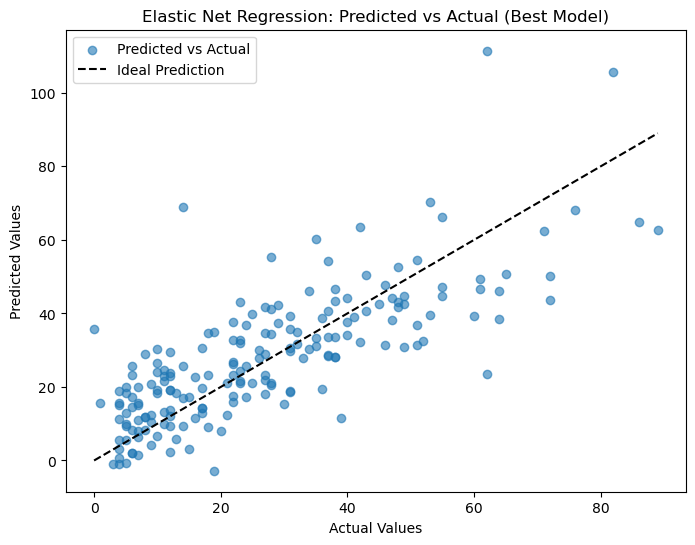

Best Parameters: {'alpha': 1.0, 'l1_ratio': 0.1}
Mean Squared Error: 163.394
R^2 Score: 0.558


({'Mean Squared Error': 163.39381088381342, 'R^2 Score': 0.5582984938738476},
 {'alpha': 1.0, 'l1_ratio': 0.1})

In [13]:

from sklearn.model_selection import ParameterGrid
def preprocess_data(X, y, task='regression'):
    """
    Preprocesses data by splitting into train-test sets and scaling features.
    For regression, no label encoding is applied.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # #UNDO SCALER
    # X_train_scaled = X_train
    # X_test_scaled = X_test
    
    return X_train_scaled, X_test_scaled, y_train, y_test
# Elastic Net Training & Evaluation with Grid Search
def train_evaluate_elastic_net_with_grid_search(X_train, X_test, y_train, y_test, alphas, l1_ratios):
    """
    Trains and evaluates Elastic Net models for a grid of hyperparameters.
    Returns the best model and its metrics.
    """
    best_model = None
    best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
    best_params = {}

    # Grid search
    param_grid = ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios})
    for params in param_grid:
        print(params)
        model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Update best model if current is better
        if mse < best_metrics['Mean Squared Error']:
            best_model = model
            best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
            best_params = params

    # Scatter plot of predictions vs actual values for the best model
    y_pred_best = best_model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
    plt.legend(loc="upper left")
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")
    
    return best_model, best_metrics, best_params

# Main Execution with Hyperparameter Grid Search
def main():
    """
    Main function for preprocessing data, training Elastic Net with grid search, and displaying results.
    """
    print("\nTraining Elastic Net with Grid Search to predict HRD probabilities:")
    
    # Example data preprocessing
    X_train, X_test, y_train, y_test = preprocess_data(features_df, labels, task='regression')
    
    # Define hyperparameter ranges
    alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
    l1_ratios = [0.1, 0.5, 0.7, 0.9]
    
    best_model, best_metrics, best_params = train_evaluate_elastic_net_with_grid_search(
        X_train, X_test, y_train, y_test, alphas, l1_ratios
    )
    
    return best_model, best_metrics, best_params

# Execute Main
elastic_net_model, elastic_net_metrics, elastic_net_params = main()
elastic_net_metrics, elastic_net_params


In [14]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

# genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)
# Drop columns that have only zeros
genes_validation_transposed = genes_validation_transposed.loc[:, ~(genes_validation_transposed == 0).all()]

# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]
breast_filt = genes_validation_transposed_sorted[genes_validation_transposed_sorted.index.str.contains('BREAST')]
breast_filt

Description,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,CICP27,AL627309.1,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
AU565_BREAST,32.0,1231.0,3.0,1.0,0.0,0.0,3.0,4.0,152.0,2582.0,...,1146916.0,6.0,3.0,8.0,389708.0,146916.0,24.0,364079.0,2.0,7.0
BT20_BREAST,21.0,853.0,2.0,0.0,1.0,3.0,4.0,10.0,141.0,3214.0,...,1643737.0,7.0,3.0,7.0,558184.0,182410.0,48.0,745031.0,1.0,6.0
BT474_BREAST,3.0,911.0,5.0,9.0,2.0,3.0,6.0,3.0,58.0,187.0,...,1169056.0,8.0,9.0,22.0,522991.0,165302.0,44.0,733933.0,10.0,3.0
BT483_BREAST,19.0,1306.0,5.0,4.0,7.0,4.0,15.0,12.0,69.0,33.0,...,1547088.0,11.0,9.0,9.0,798460.0,320052.0,45.0,1245412.0,3.0,35.0
BT549_BREAST,14.0,1214.0,8.0,11.0,6.0,3.0,7.0,11.0,42.0,57.0,...,1039147.0,12.0,4.0,16.0,513498.0,160632.0,16.0,644871.0,2.0,6.0
CAL120_BREAST,7.0,630.0,3.0,1.0,5.0,0.0,3.0,2.0,26.0,31.0,...,550124.0,9.0,3.0,6.0,281034.0,83378.0,20.0,229436.0,4.0,7.0
CAL148_BREAST,10.0,1949.0,6.0,5.0,5.0,6.0,10.0,27.0,257.0,1494.0,...,1422127.0,7.0,6.0,9.0,607899.0,212433.0,31.0,1044307.0,8.0,39.0
CAL51_BREAST,2.0,1237.0,2.0,3.0,2.0,1.0,5.0,3.0,30.0,221.0,...,785289.0,5.0,7.0,8.0,410039.0,141330.0,18.0,413946.0,4.0,8.0
CAL851_BREAST,51.0,988.0,10.0,21.0,12.0,8.0,33.0,8.0,113.0,272.0,...,4067011.0,47.0,14.0,3108.0,1621072.0,570312.0,496.0,2169530.0,14.0,95.0
CAMA1_BREAST,13.0,1312.0,11.0,6.0,6.0,7.0,9.0,17.0,99.0,59.0,...,2304663.0,17.0,17.0,1286.0,879298.0,255524.0,66.0,1431185.0,84.0,8.0


In [15]:
breast_filt = np.log2(breast_filt+1)
breast_filt.index = breast_filt.index.str.split('_').str[0]
# Align breast_filt with deseq_filtered_rna_seq_df_common columns
breast_filt_aligned = breast_filt.reindex(columns=deconvo.columns, fill_value=0)

# Check for column alignment
print("Are columns aligned?", list(breast_filt_aligned.columns) == list(deconvo.columns))

feature_columns = breast_filt_aligned.columns  # Adjust if necessary
X = breast_filt_aligned[feature_columns]

# Generate predictions
predictions = elastic_net_model.predict(X)

# Add the predictions to the DataFrame
breast_filt_aligned['Predictions'] = predictions
predictions

Are columns aligned? True


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


array([ 80.12108498,  91.60915755,  82.91532751,  59.8530502 ,
        71.66632645,  68.92881597,  70.21254824,  50.00637178,
       106.65087142,  69.75711977,  53.97674933,  77.16005278,
        79.12274564, 112.15978037,  89.72371973,  99.6537041 ,
        62.95911124,  88.38664291,  87.74103729, 101.08319367,
       103.99867063,  96.05481465, 107.96212075,  94.3266311 ,
        91.43425049, 107.93514169,  61.25999885, 120.44717269,
       100.07390003,  89.73158486,  59.8977759 ,  70.02718631,
        86.83920596,  92.69549248,  53.5065016 ,  55.89251014,
        47.86236277,  64.91615967,  52.82197466,  62.27881004,
        78.77105505,  74.53296101,  78.6987144 ,  58.33190326,
       100.33902559,  84.90601105,  69.75539771,  58.41586426,
        94.45804167,  66.13791127,  62.88082778])

In [16]:
import pandas as pd
import numpy as np

# Load the data
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 18 23_56_13 2025.csv')

# Define PARP inhibitors
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']

# Filter and select specific drugs
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']].copy()

# Apply transformations explicitly
parpi_resp_filt['IC50'] = parpi_resp_filt['IC50'].clip(lower=1e-6)
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])

parpi_resp_filt["Cell Line Name"] = parpi_resp_filt["Cell Line Name"].str.replace("-", "", regex=True)

merged_df = breast_filt_aligned.merge(
    parpi_resp_filt,
    right_on ='Cell Line Name',
    left_index=True
)
subset_df = merged_df[['Cell Line Name', 'Drug Name', 'Predictions', 'log10IC50']]
subset_df

,Cell Line Name,Drug Name,Predictions,log10IC50
31,AU565,Olaparib,80.121085,0.649300
81,AU565,Veliparib,80.121085,0.728449
275,AU565,Rucaparib,80.121085,0.618083
323,AU565,Niraparib,80.121085,0.658753
370,AU565,Talazoparib,80.121085,0.446904
...,...,...,...,...
30,ZR7530,Olaparib,62.880828,0.774099
80,ZR7530,Veliparib,62.880828,0.791624
274,ZR7530,Rucaparib,62.880828,0.785756
322,ZR7530,Niraparib,62.880828,0.690543


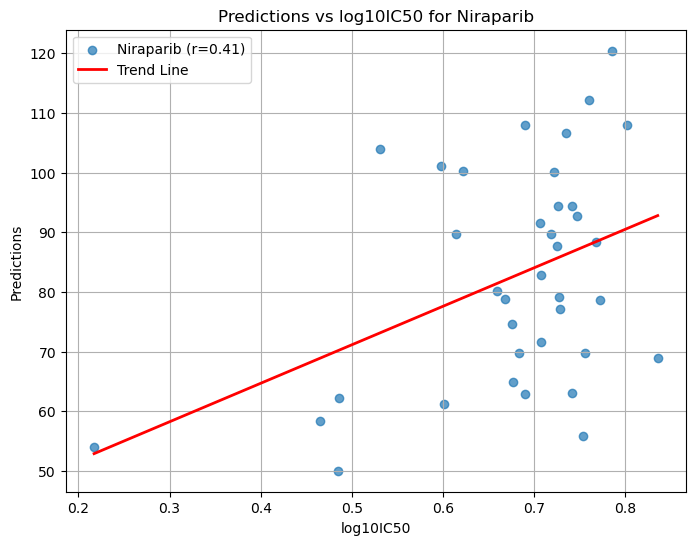

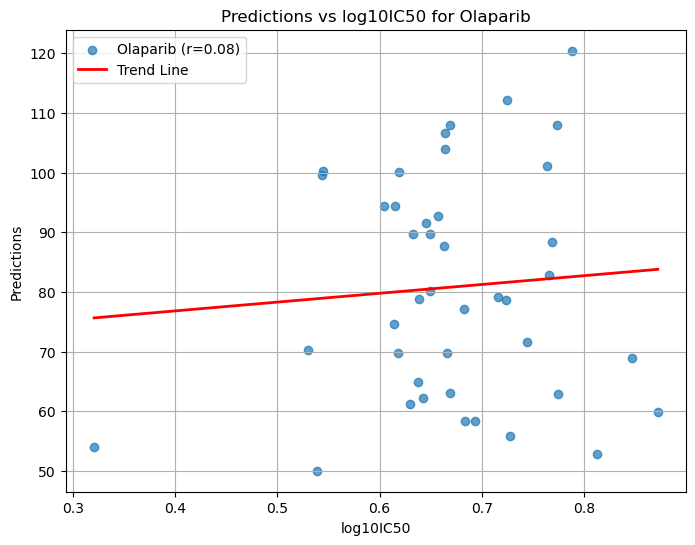

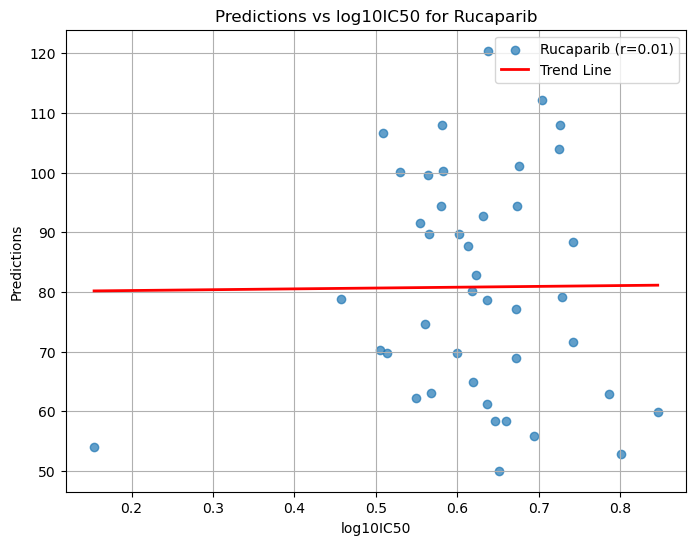

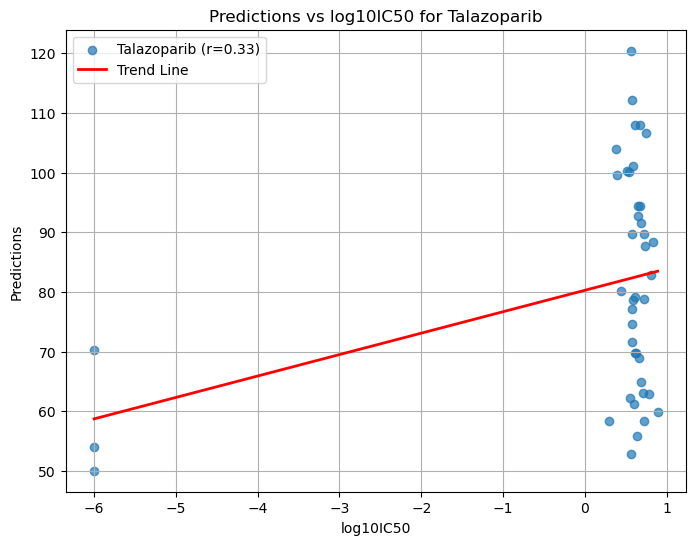

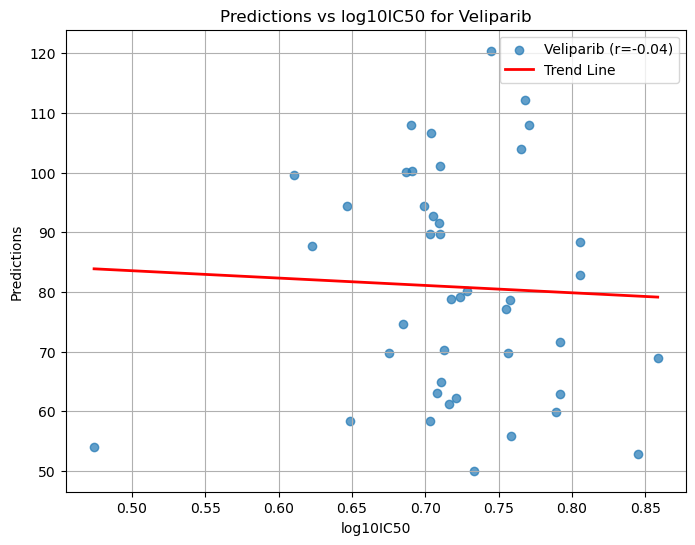

Niraparib: Correlation Coefficient = 0.41, P-Value = 0.0114
Olaparib: Correlation Coefficient = 0.08, P-Value = 0.6301
Rucaparib: Correlation Coefficient = 0.01, P-Value = 0.9583
Talazoparib: Correlation Coefficient = 0.33, P-Value = 0.0319
Veliparib: Correlation Coefficient = -0.04, P-Value = 0.7851


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from numpy.polynomial.polynomial import Polynomial

# Group the DataFrame by 'Drug Name'
grouped = merged_df.groupby('Drug Name')

# Initialize a dictionary to store correlation coefficients
correlation_results = {}

# Loop through each group and create a plot
for drug_name, group in grouped:
    # Calculate Pearson correlation coefficient
    corr_coef, p_value = pearsonr(group['log10IC50'], group['Predictions'])
    correlation_results[drug_name] = {
        'Correlation Coefficient': corr_coef,
        'P-Value': p_value
    }
    
    # Fit a linear trend line
    poly = Polynomial.fit(group['log10IC50'], group['Predictions'], deg=1)
    x_line = np.linspace(group['log10IC50'].min(), group['log10IC50'].max(), 100)
    y_line = poly(x_line)

    # Plot the scatter plot with trend line
    plt.figure(figsize=(8, 6))
    plt.scatter(group['log10IC50'], group['Predictions'], label=f'{drug_name} (r={corr_coef:.2f})', alpha=0.7)
    plt.plot(x_line, y_line, color='red', label='Trend Line', linewidth=2)
    plt.title(f'Predictions vs log10IC50 for {drug_name}')
    plt.xlabel('log10IC50')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    plt.show()

# Display correlation results
for drug, stats in correlation_results.items():
    print(f"{drug}: Correlation Coefficient = {stats['Correlation Coefficient']:.2f}, P-Value = {stats['P-Value']:.4f}")


In [41]:
# Step 1: Extract coefficients
coefficients = elastic_net_model.coef_

# Step 2: Calculate the absolute values of the coefficients
absolute_coefficients = np.abs(coefficients)

# Step 3: Get the indices of the top 300 coefficients
top_300_indices = np.argsort(absolute_coefficients)[-100:]  # Get indices of the largest 300 coefficients

# Step 4: Retrieve the corresponding column names from `deconvo`
top_300_genes = deconvo.columns[top_300_indices]

# Display the top genes
print(f"Top 300 genes associated with the model: {top_300_genes}")
top_genes = list(top_300_genes)


Top 300 genes associated with the model: Index(['S100A2', 'PPP1R12B', 'EEF1G', 'CELSR1', 'HSPB8', 'LSM3', 'BRCA1',
       'EIF3F', 'ENDOV', 'ALYREF', 'KCNK15', 'TM2D3', 'MYO5C', 'SFN', 'IDH2',
       'RND3', 'NLRC5', 'SYT7', 'AREG', 'R3HDM4', 'CXCL9', 'PRC1', 'ABCA7',
       'CORO1A', 'NDUFB5', 'PKP3', 'SMYD3', 'ZFP36', 'NPTXR', 'BSCL2',
       'TNFAIP3', 'DGAT2', 'MAP3K1', 'AMZ2', 'CHCHD7', 'ANO9', 'CAV1', 'KRT81',
       'GNA15', 'CYB5R3', 'SQLE', 'SOX10', 'LY6K', 'VEGFA', 'RRP7A', 'ATP6V0C',
       'IP6K2', 'IDH1', 'RIPK4', 'PSCA', 'EPS8L2', 'ASB7', 'TAF9', 'HSPE1',
       'COL6A1', 'TLX1', 'MFAP5', 'PDCD2', 'DOK7', 'TCN1', 'COX16', 'CD40',
       'C16orf95', 'RDH10', 'PFN2', 'NUP54', 'ASCC2', 'PIK3R3', 'PROM1',
       'PTP4A1', 'SYNM', 'DBNDD2', 'OAZ3', 'GNB1L', 'BACE2', 'SNRPA1', 'AK5',
       'TACC3', 'CLDN1', 'SLC9A3R1', 'MMP7', 'TRIM29', 'SMPDL3B', 'MT1E',
       'WDR6', 'ROPN1', 'TFAP2C', 'DDR1', 'CD52', 'PIK3CA', 'FAM3B',
       'PLEKHG4B', 'CRACR2B', 'IGF2', 'KRT17', 'SNX22'

In [42]:

actual228 = ['MXRA8',
'PRKCZ',
'MEGF6',
'FBXO2',
'UBXN10',
'SYTL1',
'CITED4',
'C1orf210',
'GPX7',
'GBP4',
'VAV3',
'MLLT11',
'ATP1A4',
'KLHDC9',
'RABGAP1L',
'FMOD',
'RAB29',
'ZBTB18',
'SH3YL1',
'ATP6V1E2',
'UBE2E3',
'FRZB',
'PPIL3',
'PECR',
'TMEM198',
'STK11IP',
'IRS1',
'KIF1A',
'NUP210',
'ALS2CL',
'IP6K2',
'DALRD3',
'APEH',
'CACNA1D',
'FHIT',
'MTRNR2L12',
'COPG1',
'DHX36',
'USP13',
'MAGEF1',
'SENP2',
'ZNF718',
'AREG',
'SLC7A11',
'MAP9',
'SORBS2',
'FRG1',
'NADK2',
'FAM174A',
'DTWD2',
'PCDHB4',
'PCDH1',
'THOC3',
'SIMC1',
'F12',
'FAM135A',
'OGFRL1',
'CD109',
'RRAGD',
'WASF1',
'ACAT2',
'SNX10',
'SCRN1',
'NCF1',
'TMEM120A',
'AZGP1',
'SMKR1',
'PODXL',
'AKR1B1',
'TMEM139',
'SPIDR',
'TPD52',
'CA13',
'ATP6V1C1',
'BAALC',
'AARD',
'EXT1',
'SAMD12',
'MAL2',
'TAF2',
'MTBP',
'ZHX1',
'FBXO32',
'SQLE',
'LRRC6',
'VLDLR',
'SIGMAR1',
'ALDH1B1',
'CKS2',
'SYK',
'PHYHD1',
'PTGES',
'BET1L',
'RIC8A',
'SIRT3',
'RNH1',
'LRRC56',
'IRF7',
'PNPLA2',
'CRACR2B',
'ASCL2',
'TSSC4',
'PPFIBP2',
'CTR9',
'CD44',
'TCN1',
'FADS2',
'ME3',
'DCUN1D5',
'CLMP',
'SPA17',
'TMEM218',
'FOXRED1',
'GLB1L2',
'ANKRD30A',
'PDCD4',
'TACC2',
'TEAD4',
'LAG3',
'ZNF605',
'ZNF10',
'BRCA2',
'N4BP2L2',
'EXOSC8',
'COG3',
'PHF11',
'EBPL',
'IPO5',
'TEX30',
'IRS2',
'CARS2',
'ING1',
'TFDP1',
'GSC',
'SLC25A29',
'JAG2',
'RASL12',
'LARP6',
'ZNF592',
'AEN',
'ACAN',
'HAPLN3',
'MFGE8',
'FANCI',
'POLG',
'ANPEP',
'ARPIN',
'GDPGP1',
'NGRN',
'HDDC3',
'UNC45A',
'RCCD1',
'PRC1',
'ASB7',
'SNRPA1',
'IL32',
'BOLA2B',
'IRX6',
'MT1G',
'PLEKHG4',
'C16orf95',
'GALNS',
'CBFA2T3',
'CPNE7',
'YWHAE',
'INPP5K',
'GABARAP',
'KDM6B',
'ZSWIM7',
'TTC19',
'LYRM9',
'UNC119',
'NEK8',
'TRAF4',
'PGAP3',
'JUP',
'ACLY',
'NKIRAS2',
'BRCA1',
'TMUB2',
'EFTUD2',
'FMNL1',
'PRR15L',
'DCAF7',
'TACO1',
'LRRC37A3',
'SLC39A11',
'ARMC7',
'MIF4GD',
'WBP2',
'EVPL',
'SEC14L1',
'TK1',
'SOCS3',
'CANT1',
'CARD14',
'RPTOR',
'ALYREF',
'FOXK2',
'FN3KRP',
'FN3K',
'TMEM241',
'MOCOS',
'NFATC1',
'C20orf96',
'RBCK1',
'FAM110A',
'SLC4A11',
'DZANK1',
'CD40',
'SLC25A23',
'LRRC8E',
'FXYD5',
'SYNE4',
'BCKDHA',
'CNFN',
'CXCL17',
'PVR',
'ZNF583',
'ZNF419',
'TMEM191B',
'TOP3B',
'PRAME',
'PLA2G6',
'NPTXR',
'ODF3B',
'PCP4',
'RSPH1']

In [43]:
print(set(top_genes) & set(actual228))
print(len(set(top_genes) & set(actual228)))

{'AREG', 'SQLE', 'SOCS3', 'ALYREF', 'IP6K2', 'CRACR2B', 'BRCA1', 'SNRPA1', 'CD40', 'PRC1', 'C16orf95', 'TCN1', 'ASB7', 'NPTXR'}
14


In [44]:
print(len(top_genes))

100


In [45]:
for i in top_genes:
    if i[0] == 'B':
        print(i)

BRCA1
BSCL2
BACE2
